In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable
from tqdm import tqdm
import pickle

In [4]:
!gdown --id 1n4VGrcmkyrwLcs6uH6jOQOD7Iy0VEx58
!unzip datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1n4VGrcmkyrwLcs6uH6jOQOD7Iy0VEx58
To: /content/datasets.zip
100% 437M/437M [00:02<00:00, 157MB/s]
Archive:  datasets.zip
   creating: datasets/
  inflating: datasets/bow_features   
  inflating: datasets/tfidf_feats_w2v  
  inflating: datasets/tfidf_features  
  inflating: datasets/w2v_words      
  inflating: datasets/X_test_avg_w2v  
  inflating: datasets/X_test_bow     
  inflating: datasets/X_test_tfidf   
  inflating: datasets/X_test_tf_w2v  
  inflating: datasets/X_train_avg_w2v  
  inflating: datasets/X_train_bow    
  inflating: datasets/X_train_tfidf  
  inflating: datasets/X_train_tf_w2v  
  inflating: datasets/y_test         
  inflating: datasets/y_train        


In [7]:
# loading bow vectors
X_train_bow = pickle.load(open("datasets/X_train_bow","rb"))
X_test_bow = pickle.load(open("datasets/X_test_bow","rb"))
bow_features = pickle.load(open("datasets/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("datasets/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("datasets/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("datasets/tfidf_features","rb"))
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("datasets/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("datasets/X_train_avg_w2v","rb"))
X_test_avgw2v = pickle.load(open("datasets/X_test_avg_w2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("datasets/X_train_tf_w2v","rb"))
X_test_tfw2v = pickle.load(open("datasets/X_test_tf_w2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('datasets/y_train',allow_pickle=True)
y_test = np.load('datasets/y_test',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (275751, 104533)
shape of X_test_bow is (118179, 104533)
shape of X_train_tfidf is (275751, 104533)
shape of X_test_tfidf is (118179, 104533)
shape of X_train_avgw2v is (275751, 50)
shape of X_test_avgw2v is (118179, 50)
shape of X_train_tfw2v is (275751, 50)
shape of X_test_tfw2v is (118179, 50)
shape of y_train is (275751,)
shape of y_test is (118179,)


## Logistic Regression

In [32]:
# helper function to plot confusion matrix
def plot_confusion_matrix(model,X_train,y_train,X_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(X_train))
    cm_test =  confusion_matrix(y_test,model.predict(X_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index=class_label, columns=class_label)
    df_test = pd.DataFrame(cm_test, index=class_label, columns=class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
        df = df_train if i==0 else df_test
        sns.heatmap(df, annot=True, fmt="d",ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
    plt.show()


# helper function to train Logistic Regression and plot Error plots
def logistic_reg(X, y):
    penalty = ['l1','l2']
    C = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
    grid={"penalty":penalty,"C":C}

    lr = LogisticRegression(solver='liblinear', class_weight={0:15,1:4})
    model=GridSearchCV(lr, grid, cv=5, return_train_score=True)
    model.fit(X, y)

    print("Model with best parameters :\n",model.best_params_)

    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      title = 'Log - L1 penalty - hyperparameter' if i ==0 else 'Log - L2 penalty hyperparameter'
      train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
      cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
      axes[i].plot(np.log(C), train_auc, label='Train AUC')
      axes[i].plot(np.log(C), cv_auc, label='CV AUC')
      axes[i].scatter(np.log(C), train_auc)
      axes[i].grid(True)
      axes[i].legend()
      axes[i].scatter(np.log(C), cv_auc)
      axes[i].set_xlabel(title)
      axes[i].set_ylabel("AUC")
      axes[i].set_title("ERROR PLOTS")
    plt.show()

    return model.best_params_


# helper function to plot roc curve for optimal k and plot confusion matrix for both train and test set
def roc_auc_cm(X_train, X_test, y_train, y_test, best_params_):
    C = best_params_['C']
    penalty = best_params_['penalty']
    lr = LogisticRegression(C=C, penalty=penalty,solver='liblinear', class_weight={0:15,1:4})
    lr = lr.fit(X_train,y_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)

    plt.grid(True)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC CURVE FOR OPTIMAL C")
    plt.show()

    #Area under ROC curve
    print('Area under Train ROC {}'.format(train_auc))
    print('Area under Test ROC {}'.format(test_auc))
    plot_confusion_matrix(lr,X_train,y_train,X_test,y_test)

    return lr, train_auc, test_auc


# helper function to display top 10 positive/negative feature
def top_features(lr, features):
    data = lr.coef_.reshape(-1,1)
    df = pd.DataFrame(data,columns=['coefficients'],index=features)
    #Top 10 negative features
    negative = df.sort_values(by='coefficients').head(10)
    #Top 10 positive features
    positive = df.sort_values(by='coefficients',ascending=False).head(10)
    print('Top 10 negative features are: \n {}'.format(negative))
    print('--'*50)
    print('Top 10 positive features are: \n {}'.format(positive))

### Bag of Words

Model with best parameters :
 {'C': 0.1, 'penalty': 'l2'}


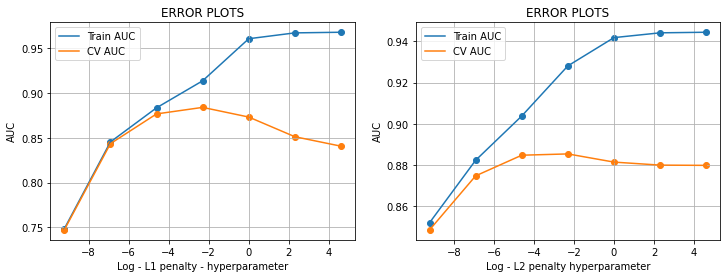

In [9]:
best_params_ = logistic_reg(X_train_bow, y_train)
C_bow = best_params_['C']
penalty_bow = best_params_['penalty']

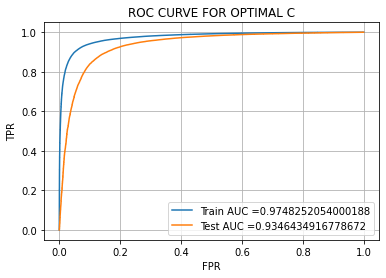

Area under Train ROC 0.9748252054000188
Area under Test ROC 0.9346434916778672


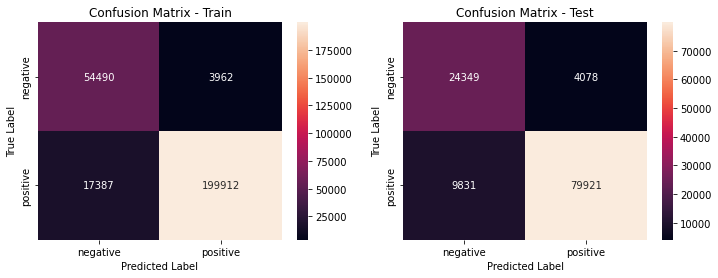

In [35]:
model, train_auc_bow, test_auc_bow = roc_auc_cm(X_train_bow, X_test_bow, y_train, y_test, best_params_)

In [11]:
top_features(model, bow_features)

Top 10 negative features are: 
                coefficients
marinata          -2.985925
foofy             -2.638540
dissapointing     -2.451427
mediocre          -2.441709
worst             -2.323420
disappointing     -2.314686
meh               -2.289600
yucatan           -2.068404
overrated         -2.048318
yuck              -1.991552
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
             coefficients
addicting       2.273031
excellant       2.120434
yum             2.054454
hooked          1.949759
mindful         1.943620
biggie          1.907534
pleasantly      1.880419
delish          1.879479
yummmm          1.835403
skeptical       1.822583


### TF-IDF

Model with best parameters :
 {'C': 1, 'penalty': 'l2'}


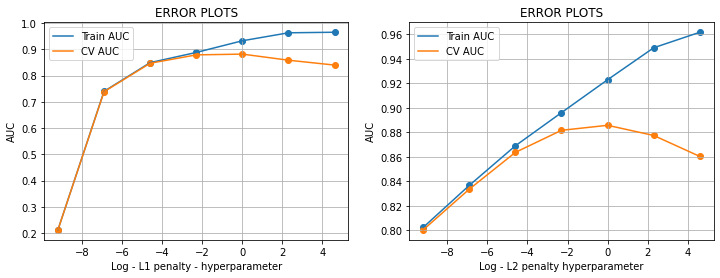

In [15]:
best_params_ = logistic_reg(X_train_tfidf, y_train)
C_tfidf = best_params_['C']
penalty_tfidf = best_params_['penalty']

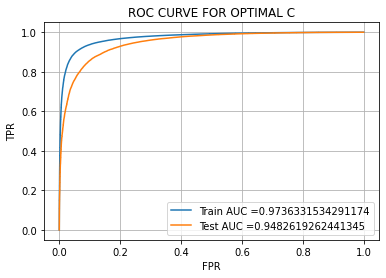

Area under Train ROC 0.9736331534291174
Area under Test ROC 0.9482619262441345


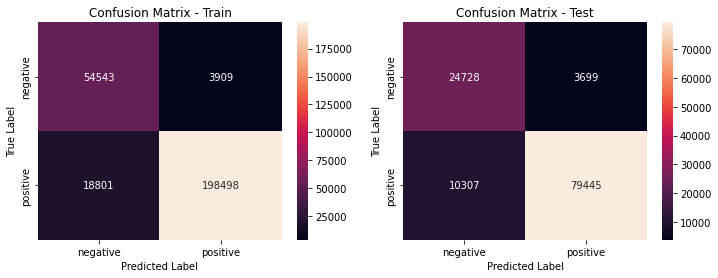

In [36]:
model, train_auc_tfidf, test_auc_tfidf = roc_auc_cm(X_train_tfidf, X_test_tfidf, y_train, y_test, best_params_)

In [17]:
top_features(model, tfidf_features)

Top 10 negative features are: 
                 coefficients
worst             -13.973019
not               -12.465804
disappointing     -12.406279
mediocre          -11.100809
disappointment    -10.069892
terrible           -9.851480
awful              -9.555128
horrible           -9.458519
yuck               -9.391882
meh                -9.262910
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
             coefficients
great          13.632965
delicious      12.798923
excellent      12.742939
best           12.567271
yum            11.613271
hooked         11.181551
perfect        11.099590
pleasantly     10.470610
highly         10.268760
wonderful      10.097306


### Average Word2Vec

Model with best parameters :
 {'C': 0.01, 'penalty': 'l2'}


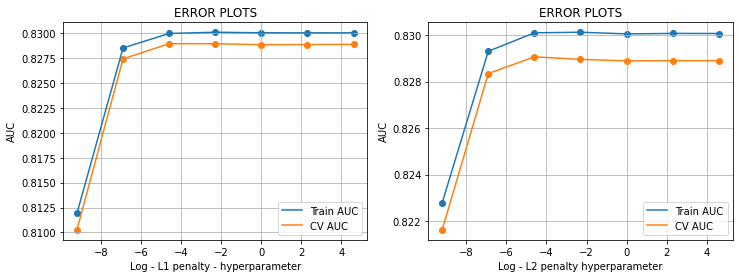

In [18]:
best_params_ = logistic_reg(X_train_avgw2v, y_train)
C_avgw2v = best_params_['C']
penalty_avgw2v = best_params_['penalty']

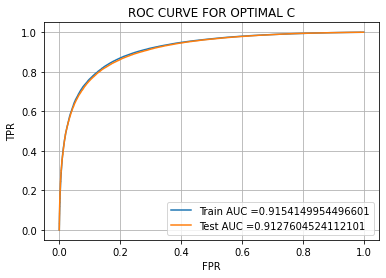

Area under Train ROC 0.9154149954496601
Area under Test ROC 0.9127604524112101


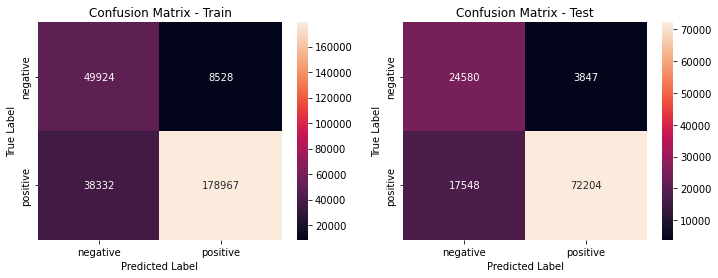

In [37]:
model, train_auc_avgw2v, test_auc_avgw2v = roc_auc_cm(X_train_avgw2v, X_test_avgw2v, y_train, y_test, best_params_)

### TF-IDF Word2Vec

Model with best parameters :
 {'C': 1.0, 'penalty': 'l1'}


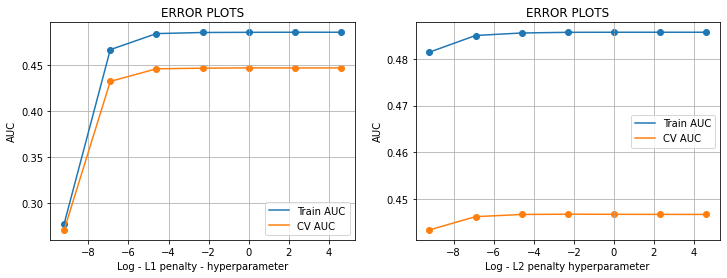

In [33]:
best_params_ = logistic_reg(X_train_tfw2v, y_train)
C_tfw2v = best_params_['C']
penalty_tfw2v = best_params_['penalty']

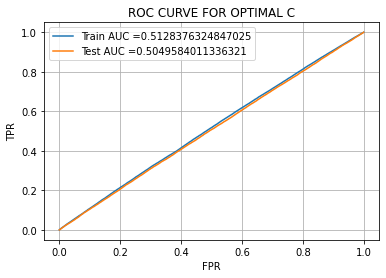

Area under Train ROC 0.5128376324847025
Area under Test ROC 0.5049584011336321


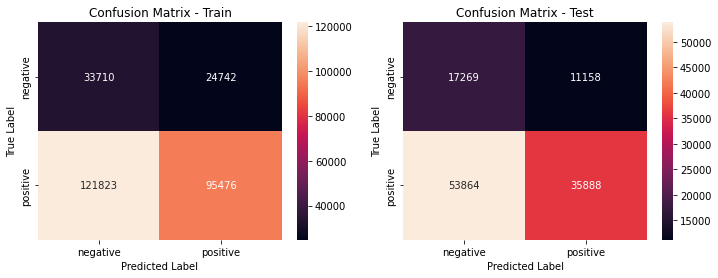

In [34]:
model, train_auc_tfw2v, test_auc_tfw2v = roc_auc_cm(X_train_tfw2v, X_test_tfw2v, y_train, y_test, best_params_)

## Observation

In [38]:
pt = PrettyTable()

pt.field_names = ["Vector", "Algorithm", "Regulariation", "Hyperparameter-C", "Train AUC", "Test AUC"]

pt.add_row(["BOW", "Logistic Regression", 
            penalty_bow, C_bow, train_auc_bow, test_auc_bow])
pt.add_row(["TF-IDF", "Logistic Regression", 
            penalty_tfidf, C_tfidf, train_auc_tfidf, test_auc_tfidf])    
pt.add_row(["Average Word2Vec", "Logistic Regression", 
            penalty_avgw2v, C_avgw2v, train_auc_avgw2v, test_auc_avgw2v])
pt.add_row(["TFIDF Word2Vec", "Logistic Regression", 
            penalty_avgw2v, C_avgw2v, train_auc_tfw2v, test_auc_tfw2v])

print(pt)

+------------------+---------------------+---------------+------------------+--------------------+--------------------+
|      Vector      |      Algorithm      | Regulariation | Hyperparameter-C |     Train AUC      |      Test AUC      |
+------------------+---------------------+---------------+------------------+--------------------+--------------------+
|       BOW        | Logistic Regression |       l2      |       0.1        | 0.9748252054000188 | 0.9346434916778672 |
|      TF-IDF      | Logistic Regression |       l2      |        1         | 0.9736331534291174 | 0.9482619262441345 |
| Average Word2Vec | Logistic Regression |       l2      |       0.01       | 0.9154149954496601 | 0.9127604524112101 |
|  TFIDF Word2Vec  | Logistic Regression |       l2      |       0.01       | 0.5128376324847025 | 0.5049584011336321 |
+------------------+---------------------+---------------+------------------+--------------------+--------------------+
